In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 53.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import json
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
import re
import cv2
import pandas as pd

In [3]:
dates = []
areas = []
upper_areas = []
lower_areas = []
classified_water_images = []
shapefile_path = "/kaggle/input/india-shapefiles/States.shp"
gdf = gpd.read_file(shapefile_path)
shapes = [json.loads(gdf.geometry.to_json())['features'][14]['geometry']]

In [4]:
shapefile_path = "/kaggle/input/india-shapefiles/States.shp"
gdf = gpd.read_file(shapefile_path)
state_shape = [json.loads(gdf.to_crs("EPSG:4326").geometry.to_json())['features'][14]['geometry']]

def extract(image_path):
    filename = os.path.basename(image_path)
    match = re.search(r'\d{6}', filename)
    if match:
        date_str = match.group()
        dates.append(int(date_str))
    else:
        return None
    with rasterio.open(image_path) as src:
        shapes_transformed = rasterio.warp.transform_geom("EPSG:4326", src.crs.to_string(), state_shape[0])
        out_image, _ = mask(src, [shapes_transformed], crop=True)
        image_array = out_image.transpose(1, 2, 0)
        image_array = np.clip(image_array, 0, 255).astype(np.uint8)
        return image_array

def downscaling(img, scale_factor=2.5, method='lanczos'):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == 255:
                img[i][j] = 0
    h, w = img.shape[:2]
    new_size = (int(w * scale_factor), int(h * scale_factor))
    methods = {
        'nearest': cv2.INTER_NEAREST,
        'bilinear': cv2.INTER_LINEAR,
        'bicubic': cv2.INTER_CUBIC,
        'lanczos': cv2.INTER_LANCZOS4,
    }
    downscaled = cv2.resize(img, new_size, interpolation=methods[method])
    return downscaled

def otsu_thresh(image):
    nonzero_pixels = image[image > 0]
    nonzero_norm = (nonzero_pixels - nonzero_pixels.min()) / (nonzero_pixels.max() - nonzero_pixels.min())
    global_thresh = threshold_otsu(nonzero_norm)
    water_pixels = nonzero_norm[nonzero_norm < global_thresh]

    if len(water_pixels) > 0:
        local_thresh = threshold_otsu(water_pixels)
    else:
        local_thresh = global_thresh / 2

    classified = np.zeros_like(image, dtype=np.float32)
    valid_mask = image > 0

    normalized_image = (image[valid_mask] - nonzero_pixels.min()) / (nonzero_pixels.max() - nonzero_pixels.min())
    class_values = np.where(
        normalized_image < local_thresh,
        0.33,
        np.where(
            normalized_image < global_thresh,
            0.66,
            1.0
        )
    )
    classified[valid_mask] = class_values

    permanent_count = np.sum(classified == 0.33)
    temporary_count = np.sum(classified == 0.66)
    areas.append([permanent_count, temporary_count])

    h = image.shape[0]
    upper_half = classified[:h // 2]
    lower_half = classified[h // 2:]

    upper_permanent = np.sum(upper_half == 0.33)
    upper_temp = np.sum(upper_half == 0.66)
    upper_areas.append([upper_permanent, upper_temp])

    lower_permanent = np.sum(lower_half == 0.33)
    lower_temp = np.sum(lower_half == 0.66)
    lower_areas.append([lower_permanent, lower_temp])

    return classified

def s_avg(areas):
    seasonal_averages = []
    for i in range(1,234,4):
        seasonal_permanent = (areas[i+1][0]+areas[i+2][0]+areas[i+3][0]+areas[i+4][0])/4
        seasonal_temp     = (areas[i+1][1]+areas[i+2][1]+areas[i+3][1]+areas[i+4][1])/4
        seasonal_averages.append([seasonal_permanent,seasonal_temp])
    return seasonal_averages
def y_avg(areas):
    yearly_averages = []
    for i in range(0, 240, 12):
        yearly_permanent = sum([areas[i + j][0] for j in range(12)]) / 12
        yearly_temp      = sum([areas[i + j][1] for j in range(12)]) / 12
        yearly_averages.append([yearly_permanent, yearly_temp])
    return yearly_averages

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        uttarakhand_region = extract(image_path)
        if uttarakhand_region is not None:
            downscaled = downscaling(uttarakhand_region, scale_factor=2.5, method='lanczos')
            classified = otsu_thresh(downscaled)
            classified_water_images.append(classified)

In [23]:
def plot_separate(areas):
    seasonal = s_avg(areas)
    yearly = y_avg(areas)

    perm = [a[0] for a in areas]
    temp = [a[1] for a in areas]
    
    s_perm = [s[0] for s in seasonal]
    s_temp = [s[1] for s in seasonal]
    
    y_perm = [y[0] for y in yearly]
    y_temp = [y[1] for y in yearly]

    monthly_dates = pd.date_range(start='2003-01-01', periods=len(areas), freq='MS')
    seasonal_dates = pd.date_range(start='2003-05-01', periods=len(seasonal), freq='4MS')
    yearly_dates = pd.date_range(start='2003-01-01', periods=len(yearly), freq='12MS')

    plt.figure(figsize=(18, 5))

    # Monthly
    plt.subplot(1, 3, 1)
    plt.plot(monthly_dates, perm, label='Permanent', color='blue', marker='o')
    plt.plot(monthly_dates, temp, label='Temporary', color='orange', marker='x')
    plt.title("Monthly Areas")
    plt.xlabel("Date")
    plt.ylabel("Area(in sq. km)")
    plt.legend()
    plt.grid(True)

    # Seasonal
    plt.subplot(1, 3, 2)
    plt.plot(seasonal_dates, s_perm, label='Permanent (Seasonal Avg)', color='blue', marker='o')
    plt.plot(seasonal_dates, s_temp, label='Temporary (Seasonal Avg)', color='orange', marker='x')
    plt.title("Seasonal Averages")
    plt.xlabel("Date")
    plt.ylabel("Area(in sq. km)")
    plt.legend()
    plt.grid(True)

    # Yearly
    plt.subplot(1, 3, 3)
    plt.plot(yearly_dates, y_perm, label='Permanent (Yearly Avg)', color='blue', marker='o')
    plt.plot(yearly_dates, y_temp, label='Temporary (Yearly Avg)', color='orange', marker='x')
    plt.title("Yearly Averages")
    plt.xlabel("Date")
    plt.ylabel("Area(in sq. km)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_all(areas):
    seasonal = s_avg(areas)
    yearly = y_avg(areas)

    perm = [a[0] for a in areas]
    temp = [a[1] for a in areas]
    
    s_perm = [s[0] for s in seasonal]
    s_temp = [s[1] for s in seasonal]
    
    y_perm = [y[0] for y in yearly]
    y_temp = [y[1] for y in yearly]

    monthly_dates = pd.date_range(start='2003-01-01', periods=len(areas), freq='MS')
    seasonal_dates = pd.date_range(start='2003-05-01', periods=len(seasonal), freq='4MS')
    yearly_dates = pd.date_range(start='2003-01-01', periods=len(yearly), freq='12MS')

    plt.figure(figsize=(14, 6))
    plt.plot(monthly_dates, perm, label='Permanent (Monthly)', color='blue')
    plt.plot(monthly_dates, temp, label='Temporary (Monthly)', color='orange')
    plt.plot(seasonal_dates, s_perm, linestyle='-.', marker='x', label='Permanent (Seasonal Avg)', color='blue')
    plt.plot(seasonal_dates, s_temp, linestyle='-.', marker='x', label='Temporary (Seasonal Avg)', color='orange')
    plt.plot(yearly_dates, y_perm, 'o-', label='Permanent (Yearly Avg)', color='blue')
    plt.plot(yearly_dates, y_temp, 'o-', label='Temporary (Yearly Avg)', color='orange')

    plt.title("Permanent and Temporary Areas - Monthly, Seasonal, and Yearly")
    plt.xlabel("Date")
    plt.ylabel("Area(in sq. km)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_image(img):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 2)
    plt.title("Water Classification")
    plt.imshow(img, cmap='Blues', vmin=0, vmax=1)
    cbar = plt.colorbar(ticks=[0.33, 0.66, 0])
    cbar.ax.set_yticklabels(['Permanent', 'Temporary', 'Land'])
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_continous(areas):
    permanent_areas = [item[0] for item in areas]
    temporary_areas = [item[1] for item in areas]
    
    dates = pd.date_range(start='2003-01-01', periods=len(areas), freq='MS')
    
    plt.figure(figsize=(12, 6))
    plt.plot(dates, permanent_areas, label='Permanent Area', color='blue', marker='o')
    plt.plot(dates, temporary_areas, label='Temporary Area', color='orange', marker='x')
    
    plt.title("Permanent vs Temporary Areas by Date")
    plt.xlabel("Date")
    plt.ylabel("Area(in sq. km)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

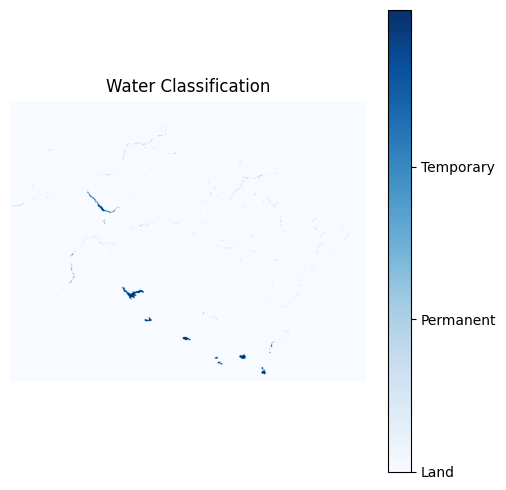

In [8]:
plot_image(classified_water_images[238])

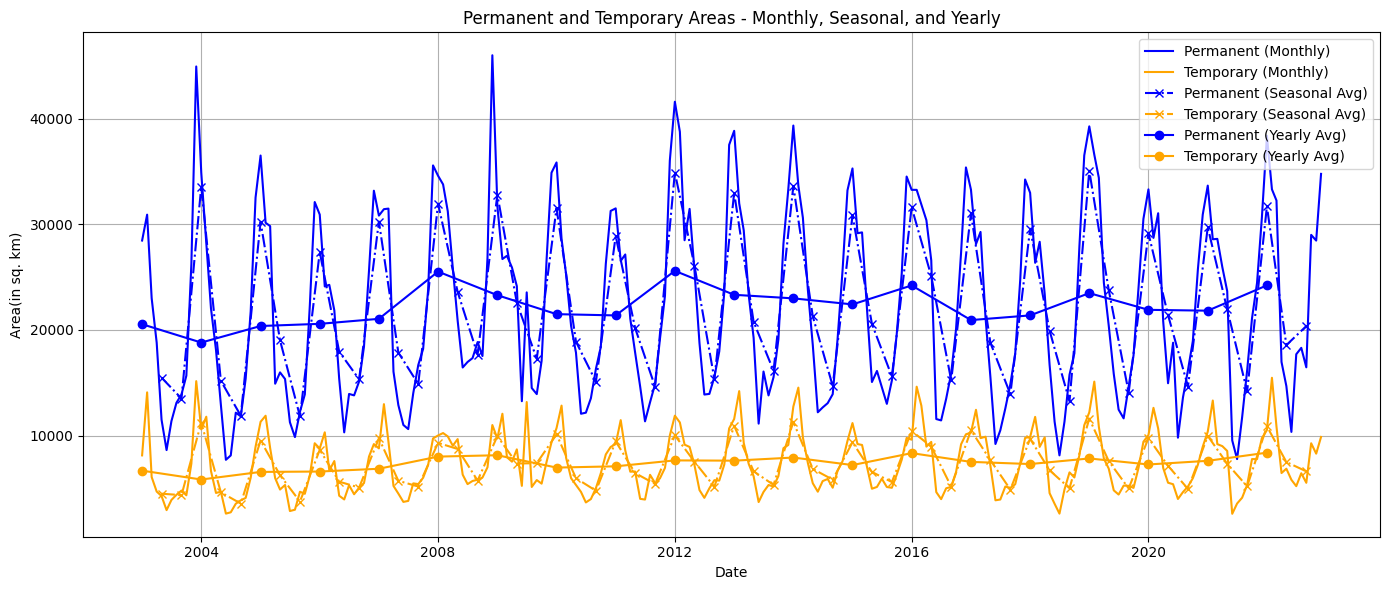

In [24]:
plot_all(areas)

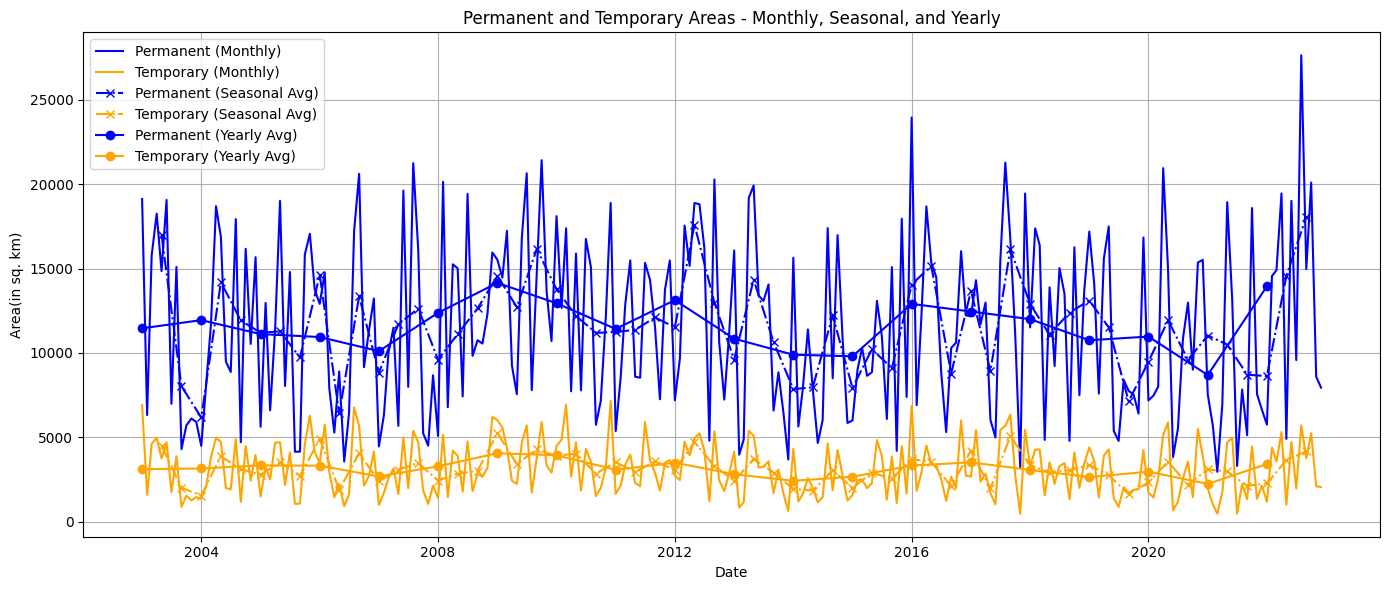

In [27]:
plot_all(upper_areas)

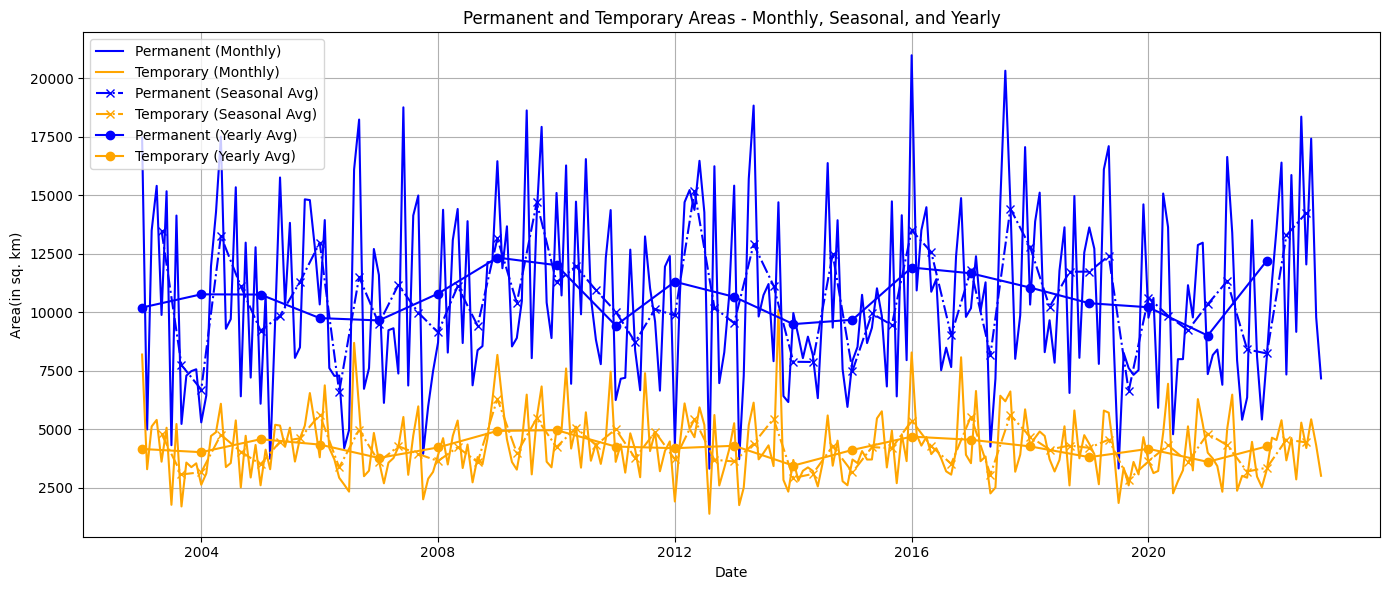

In [25]:
plot_all(lower_areas)

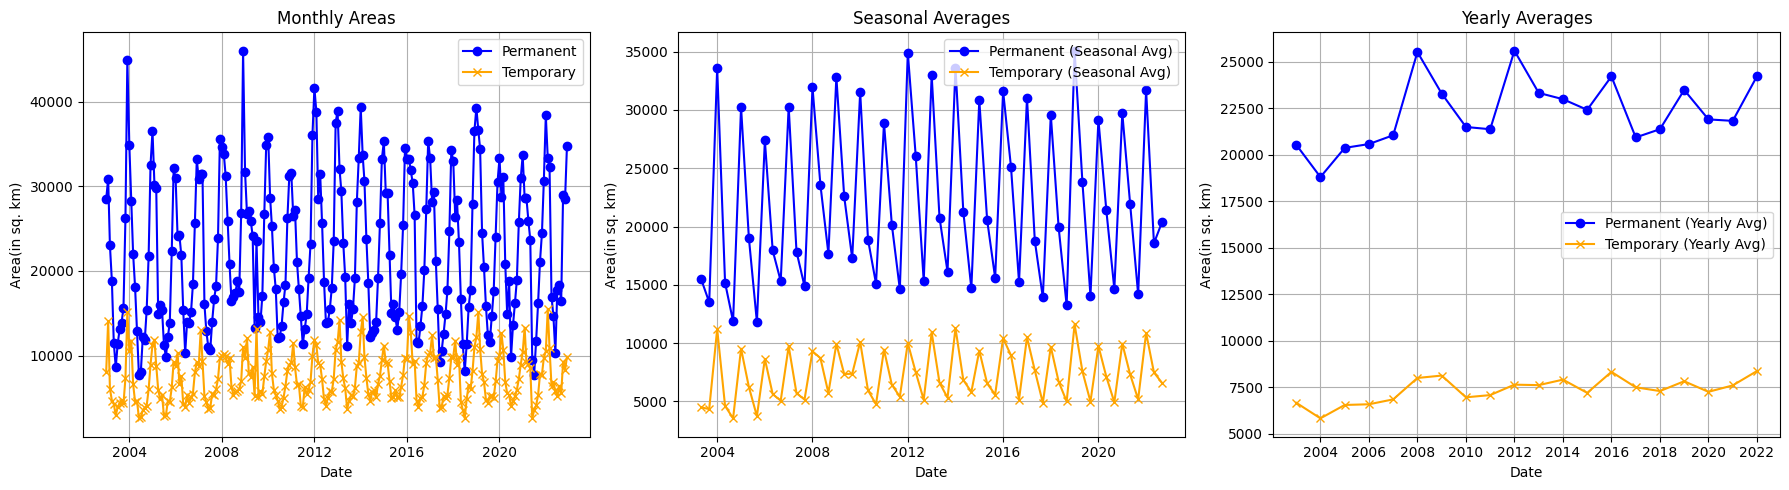

In [26]:
plot_separate(areas)

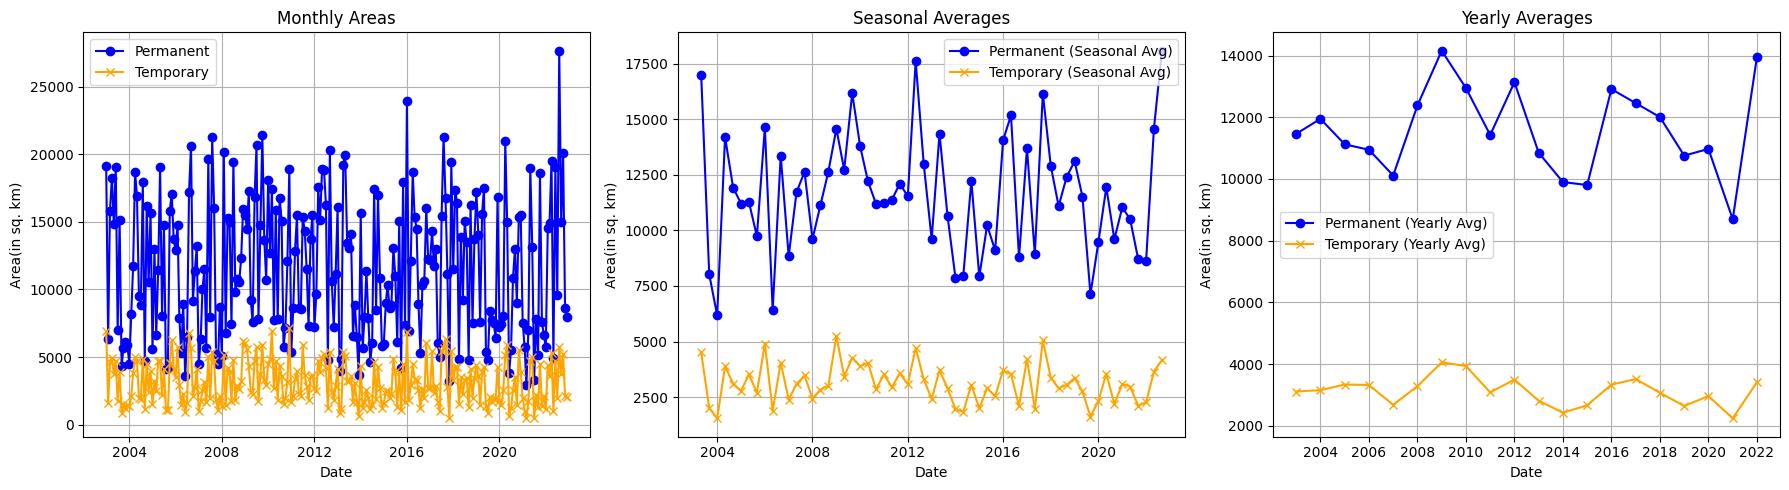

In [16]:
plot_separate(upper_areas)

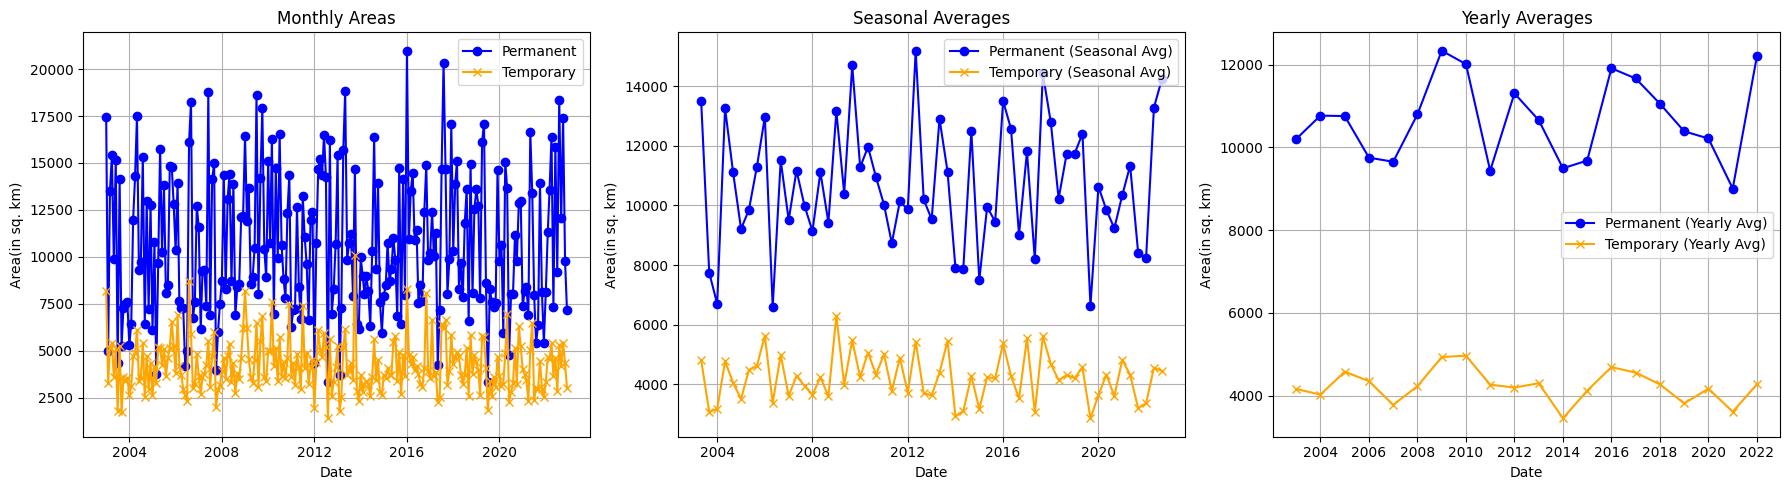

In [15]:
plot_separate(lower_areas)